In [1]:
!pip install geopy
!pip install tqdm
!pip install BeautifulSoup4
!conda install seaborn
!pip install folium

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import json
from geopy.geocoders import Nominatim
from tqdm import tqdm
from geopy.extra.rate_limiter import RateLimiter
from math import sqrt, pi
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN 
from sklearn.cluster import KMeans 
import folium

%matplotlib inline

Solving environment: done

# All requested packages already installed.



In [2]:
#import Edmonton neighbourhoods Information
yeg_hoods = pd.read_csv("https://data.edmonton.ca/api/views/3b6m-fezs/rows.csv")
yeg_hoods

,Neighbourhood Number,Neighbourhood Name,Area Sq Km,Latitude,Longitude,Location
0,2463,Crystallina Nera West,0.857044,53.640320,-113.460383,"(53.64032041132357, -113.46038345742033)"
1,2462,Crystallina Nera East,0.841843,53.640784,-113.448768,"(53.64078411972238, -113.44876804448046)"
2,4150,Gagnon Estate Industrial,0.556701,53.580184,-113.585795,"(53.58018417365767, -113.58579493909596)"
3,6390,Larkspur,1.658195,53.480210,-113.381240,"(53.4802104573005, -113.38123994870551)"
4,4440,River Valley Lessard North,0.794190,53.504195,-113.584827,"(53.504195315820766, -113.58482693803155)"
...,...,...,...,...,...,...
396,6160,Davies Industrial East,1.634026,53.506189,-113.433140,"(53.50618932074611, -113.43313995126871)"
397,1210,Riverdale,1.068524,53.544107,-113.469011,"(53.54410729040709, -113.46901088237121)"
398,6510,Mill Woods Park,0.490425,53.455865,-113.441306,"(53.4558654123871, -113.44130550418193)"
399,5280,Malmo Plains,0.940941,53.485677,-113.528992,"(53.48567699317607, -113.52899210582925)"


In [3]:
#import Crime Data i.e. # Occurrences for each Edmonton Neighbourhood
yeg_crime_import = pd.read_csv("https://dashboard.edmonton.ca/api/views/xthe-mnvi/rows.csv")
yeg_crime_import

,Neighbourhood Description (Occurrence),Occurrence Violation Type Group,Occurrence Reported Year,Occurrence Reported Quarter,Occurrence Reported Month,# Occurrences
0,ABBOTTSFIELD,Assault,2009,Q1,1,3
1,ABBOTTSFIELD,Assault,2009,Q1,2,5
2,ABBOTTSFIELD,Assault,2009,Q1,3,2
3,ABBOTTSFIELD,Assault,2009,Q2,4,2
4,ABBOTTSFIELD,Assault,2009,Q2,5,6
...,...,...,...,...,...,...
113072,YORK,Theft Over $5000,2019,Q1,1,2
113073,YORK,Theft Over $5000,2019,Q2,6,1
113074,YORK,Theft Over $5000,2019,Q3,8,2
113075,YOUNGSTOWN INDUSTRIAL,Theft Over $5000,2019,Q2,5,1


In [4]:
# aggregate number of Criminal Occurrences from all the years for each neighbourhood
yeg_crime_grouped = yeg_crime_import.groupby(['Neighbourhood Description (Occurrence)']).sum()
yeg_crime_grouped

,Occurrence Reported Year,Occurrence Reported Month,# Occurrences
Neighbourhood Description (Occurrence),,,
ABBOTTSFIELD,952553,3011,976
ALBANY,320557,1102,221
ALBERTA AVENUE,1510451,4813,5048
ALBERTA PARK INDUSTRIAL,368566,1160,260
ALDERGROVE,938520,2992,937
...,...,...,...
WOODCROFT,1109690,3567,1334
YELLOWHEAD CORRIDOR EAST,811658,2632,808
YELLOWHEAD CORRIDOR WEST,84646,268,51


In [5]:
# clean up the crime grouped table
yeg_crime_df=yeg_crime_grouped.drop(['Occurrence Reported Year', 'Occurrence Reported Month'],axis=1)
yeg_crime_df

,# Occurrences
Neighbourhood Description (Occurrence),
ABBOTTSFIELD,976
ALBANY,221
ALBERTA AVENUE,5048
ALBERTA PARK INDUSTRIAL,260
ALDERGROVE,937
...,...
WOODCROFT,1334
YELLOWHEAD CORRIDOR EAST,808
YELLOWHEAD CORRIDOR WEST,51


In [6]:
# import Property Assessed Value data
yeg_price_import = pd.read_csv("https://data.edmonton.ca/api/views/q7d6-ambg/rows.csv")
yeg_price_import

,Account Number,Suite,House Number,Street Name,Garage,Neighbourhood ID,Neighbourhood,Ward,Assessed Value,Latitude,Longitude,Point Location,Assessment Class % 1,Assessment Class % 2,Assessment Class % 3,Assessment Class 1,Assessment Class 2,Assessment Class 3
0,10511144,NaN,2144.0,CASSIDY WYND SW,Y,5462.0,CHAPPELLE AREA,Ward 10,346500,53.404221,-113.579937,POINT (-113.57993746472 53.4042210287108),100,NaN,NaN,RESIDENTIAL,NaN,NaN
1,10744801,NaN,NaN,NaN,N,2700.0,SCHONSEE,Ward 3,9000,53.633750,-113.460824,POINT (-113.46082384640201 53.63375023394092),100,NaN,NaN,RESIDENTIAL,NaN,NaN
2,10510744,NaN,17831.0,78 STREET NW,Y,2463.0,CRYSTALLINA NERA WEST,Ward 3,597500,53.640587,-113.463561,POINT (-113.463561005362 53.6405867945432),100,NaN,NaN,RESIDENTIAL,NaN,NaN
3,10736185,NaN,2534.0,CASEY WAY SW,Y,5467.0,CAVANAGH,Ward 12,348500,53.408832,-113.506632,POINT (-113.50663237577 53.4088318120474),100,NaN,NaN,RESIDENTIAL,NaN,NaN
4,10735766,NaN,NaN,NaN,N,5451.0,RICHFORD,Ward 10,9000,53.425827,-113.515391,POINT (-113.51539071946416 53.42582727250219),100,NaN,NaN,RESIDENTIAL,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407240,10697454,NaN,1305.0,HAINSTOCK WAY SW,Y,5465.0,HAYS RIDGE AREA,Ward 9,874500,53.416022,-113.570187,POINT (-113.570186534283 53.4160217369973),100,NaN,NaN,RESIDENTIAL,NaN,NaN
407241,10512154,NaN,7262.0,MORGAN ROAD NW,Y,3111.0,GRIESBACH,Ward 2,532000,53.609073,-113.516170,POINT (-113.516169688935 53.6090727564879),100,NaN,NaN,RESIDENTIAL,NaN,NaN
407242,10718798,NaN,10536.0,83 STREET NW,Y,6230.0,FOREST HEIGHTS,Ward 8,571500,53.548916,-113.456020,POINT (-113.45602007568 53.5489155045793),100,NaN,NaN,RESIDENTIAL,NaN,NaN
407243,10713811,212,667.0,WATT BOULEVARD SW,N,6662.0,WALKER,Ward 12,176500,53.423287,-113.437818,POINT (-113.43781833968268 53.42328681463384),100,NaN,NaN,RESIDENTIAL,NaN,NaN


In [7]:
# clean Assessed Value table
yeg_price_clean = yeg_price_import.drop([ 'Suite', 'House Number', 'Street Name', 'Garage','Assessment Class % 1',
       'Assessment Class % 2', 'Assessment Class % 3', 'Assessment Class 1',
       'Assessment Class 2', 'Assessment Class 3', 'Point Location'],axis=1)
yeg_price_clean

,Account Number,Neighbourhood ID,Neighbourhood,Ward,Assessed Value,Latitude,Longitude
0,10511144,5462.0,CHAPPELLE AREA,Ward 10,346500,53.404221,-113.579937
1,10744801,2700.0,SCHONSEE,Ward 3,9000,53.633750,-113.460824
2,10510744,2463.0,CRYSTALLINA NERA WEST,Ward 3,597500,53.640587,-113.463561
3,10736185,5467.0,CAVANAGH,Ward 12,348500,53.408832,-113.506632
4,10735766,5451.0,RICHFORD,Ward 10,9000,53.425827,-113.515391
...,...,...,...,...,...,...,...
407240,10697454,5465.0,HAYS RIDGE AREA,Ward 9,874500,53.416022,-113.570187
407241,10512154,3111.0,GRIESBACH,Ward 2,532000,53.609073,-113.516170
407242,10718798,6230.0,FOREST HEIGHTS,Ward 8,571500,53.548916,-113.456020
407243,10713811,6662.0,WALKER,Ward 12,176500,53.423287,-113.437818


In [8]:
# aggregate Assessed Value Data
yeg_price_df=yeg_price_clean.groupby(['Neighbourhood', 'Neighbourhood ID'], as_index = False).agg({'Ward':'first', 'Assessed Value':'mean',
       'Latitude':'first', 'Longitude':'first'})
yeg_price_df

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude
0,ABBOTTSFIELD,2010.0,Ward 7,3.179302e+05,53.571447,-113.388427
1,ALBANY,3460.0,Ward 2,2.983504e+05,53.629331,-113.556717
2,ALBERTA AVENUE,1010.0,Ward 2,2.718814e+05,53.569619,-113.482295
3,ALBERTA PARK INDUSTRIAL,4010.0,Ward 1,3.121061e+06,53.569709,-113.596230
4,ALDERGROVE,4020.0,Ward 1,3.369428e+05,53.513516,-113.643811
...,...,...,...,...,...,...
395,WOODCROFT,3450.0,Ward 2,5.616988e+05,53.564741,-113.552762
396,YELLOWHEAD CORRIDOR EAST,1270.0,Ward 2,1.388468e+06,53.582008,-113.472229
397,YELLOWHEAD CORRIDOR WEST,1280.0,Ward 2,5.469147e+06,53.584398,-113.538631
398,YORK,2720.0,Ward 3,3.611330e+05,53.601708,-113.440623


In [9]:
# convert Assessed Value to integer
yeg_price_df['Assessed Value'] = yeg_price_df['Assessed Value'].astype(int)
yeg_price_df

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude
0,ABBOTTSFIELD,2010.0,Ward 7,317930,53.571447,-113.388427
1,ALBANY,3460.0,Ward 2,298350,53.629331,-113.556717
2,ALBERTA AVENUE,1010.0,Ward 2,271881,53.569619,-113.482295
3,ALBERTA PARK INDUSTRIAL,4010.0,Ward 1,3121060,53.569709,-113.596230
4,ALDERGROVE,4020.0,Ward 1,336942,53.513516,-113.643811
...,...,...,...,...,...,...
395,WOODCROFT,3450.0,Ward 2,561698,53.564741,-113.552762
396,YELLOWHEAD CORRIDOR EAST,1270.0,Ward 2,1388467,53.582008,-113.472229
397,YELLOWHEAD CORRIDOR WEST,1280.0,Ward 2,5469147,53.584398,-113.538631
398,YORK,2720.0,Ward 3,361133,53.601708,-113.440623


In [10]:
# import Edmonton's population by neoiugbourhood data
yeg_popu_import = pd.read_csv("https://data.edmonton.ca/api/views/akuj-yrqt/rows.csv")
yeg_popu_import

,Ward,Neighbourhood Number,Neighbourhood Name,Woman/girl,Man/boy,Identified as another gender,Prefer Not to Answer
0,Ward 1,4010,Alberta Park Industrial,0,0,0,0
1,Ward 1,4020,Aldergrove,2523,2479,14,288
2,Ward 1,4011,Anthony Henday,0,0,0,0
3,Ward 1,4018,Anthony Henday Big Lake,0,0,0,0
4,Ward 1,4030,Armstrong Industrial,170,0,0,0
...,...,...,...,...,...,...,...
394,Ward 9,5642,South Terwillegar,4635,4566,8,544
395,Ward 9,5640,Terwillegar Towne,3313,2944,12,257
396,Ward 9,5565,Whitemud Creek Ravine Twin Brooks,0,0,0,0
397,Ward 9,5570,Windermere,5272,5200,21,758


In [11]:
# create a total population by adding different columns within the population import table
sum_column = yeg_popu_import['Woman/girl'] + yeg_popu_import['Man/boy'] + yeg_popu_import['Identified as another gender']
yeg_popu_import['Population'] = sum_column
yeg_popu_import

,Ward,Neighbourhood Number,Neighbourhood Name,Woman/girl,Man/boy,Identified as another gender,Prefer Not to Answer,Population
0,Ward 1,4010,Alberta Park Industrial,0,0,0,0,0
1,Ward 1,4020,Aldergrove,2523,2479,14,288,5016
2,Ward 1,4011,Anthony Henday,0,0,0,0,0
3,Ward 1,4018,Anthony Henday Big Lake,0,0,0,0,0
4,Ward 1,4030,Armstrong Industrial,170,0,0,0,170
...,...,...,...,...,...,...,...,...
394,Ward 9,5642,South Terwillegar,4635,4566,8,544,9209
395,Ward 9,5640,Terwillegar Towne,3313,2944,12,257,6269
396,Ward 9,5565,Whitemud Creek Ravine Twin Brooks,0,0,0,0,0
397,Ward 9,5570,Windermere,5272,5200,21,758,10493


In [12]:
# combine Edmonton Assessed Value data with Edmonton Crime Data
yeg_crime_value=pd.merge(yeg_price_df, yeg_crime_df, how ='inner', left_on = 'Neighbourhood', right_on = 'Neighbourhood Description (Occurrence)', validate ="1:m")
yeg_crime_value

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude,# Occurrences
0,ABBOTTSFIELD,2010.0,Ward 7,317930,53.571447,-113.388427,976
1,ALBANY,3460.0,Ward 2,298350,53.629331,-113.556717,221
2,ALBERTA AVENUE,1010.0,Ward 2,271881,53.569619,-113.482295,5048
3,ALBERTA PARK INDUSTRIAL,4010.0,Ward 1,3121060,53.569709,-113.596230,260
4,ALDERGROVE,4020.0,Ward 1,336942,53.513516,-113.643811,937
...,...,...,...,...,...,...,...
379,WOODCROFT,3450.0,Ward 2,561698,53.564741,-113.552762,1334
380,YELLOWHEAD CORRIDOR EAST,1270.0,Ward 2,1388467,53.582008,-113.472229,808
381,YELLOWHEAD CORRIDOR WEST,1280.0,Ward 2,5469147,53.584398,-113.538631,51
382,YORK,2720.0,Ward 3,361133,53.601708,-113.440623,1129


In [13]:
#combine Edmonton population with Edmonton # Criminal Occurrences and Assessed Value
yeg_merge1=pd.merge(yeg_crime_value, yeg_popu_import, how ='inner', left_on = 'Neighbourhood ID', right_on = 'Neighbourhood Number', validate ="1:m")
yeg_merge1

,Neighbourhood,Neighbourhood ID,Ward_x,Assessed Value,Latitude,Longitude,# Occurrences,Ward_y,Neighbourhood Number,Neighbourhood Name,Woman/girl,Man/boy,Identified as another gender,Prefer Not to Answer,Population
0,ABBOTTSFIELD,2010.0,Ward 7,317930,53.571447,-113.388427,976,Ward 7,2010,Abbottsfield,803,709,3,260,1515
1,ALBANY,3460.0,Ward 2,298350,53.629331,-113.556717,221,Ward 2,3460,Albany,765,730,3,278,1498
2,ALBERTA AVENUE,1010.0,Ward 2,271881,53.569619,-113.482295,5048,Ward 7,1010,Alberta Avenue,2512,2554,35,1480,5101
3,ALBERTA PARK INDUSTRIAL,4010.0,Ward 1,3121060,53.569709,-113.596230,260,Ward 1,4010,Alberta Park Industrial,0,0,0,0,0
4,ALDERGROVE,4020.0,Ward 1,336942,53.513516,-113.643811,937,Ward 1,4020,Aldergrove,2523,2479,14,288,5016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,WOODCROFT,3450.0,Ward 2,561698,53.564741,-113.552762,1334,Ward 2,3450,Woodcroft,1249,1104,9,241,2362
380,YELLOWHEAD CORRIDOR EAST,1270.0,Ward 2,1388467,53.582008,-113.472229,808,Ward 7,1270,Yellowhead Corridor East,0,0,0,0,0
381,YELLOWHEAD CORRIDOR WEST,1280.0,Ward 2,5469147,53.584398,-113.538631,51,Ward 2,1280,Yellowhead Corridor West,0,0,0,0,0
382,YORK,2720.0,Ward 3,361133,53.601708,-113.440623,1129,Ward 4,2720,York,1482,1413,14,1008,2909


In [14]:
# add area 
yeg_df1 = pd.merge(yeg_merge1, yeg_hoods, how ='inner', left_on = 'Neighbourhood ID', right_on = 'Neighbourhood Number', validate ="1:m")
yeg_df1

,Neighbourhood,Neighbourhood ID,Ward_x,Assessed Value,Latitude_x,Longitude_x,# Occurrences,Ward_y,Neighbourhood Number_x,Neighbourhood Name_x,...,Man/boy,Identified as another gender,Prefer Not to Answer,Population,Neighbourhood Number_y,Neighbourhood Name_y,Area Sq Km,Latitude_y,Longitude_y,Location
0,ABBOTTSFIELD,2010.0,Ward 7,317930,53.571447,-113.388427,976,Ward 7,2010,Abbottsfield,...,709,3,260,1515,2010,Abbottsfield,0.409629,53.574143,-113.388758,"(53.574143433510216, -113.38875800516438)"
1,ALBANY,3460.0,Ward 2,298350,53.629331,-113.556717,221,Ward 2,3460,Albany,...,730,3,278,1498,3460,Albany,0.843312,53.632382,-113.549464,"(53.63238214011547, -113.54946433166832)"
2,ALBERTA AVENUE,1010.0,Ward 2,271881,53.569619,-113.482295,5048,Ward 7,1010,Alberta Avenue,...,2554,35,1480,5101,1010,Alberta Avenue,1.680471,53.568485,-113.485119,"(53.568485381482176, -113.48511916925099)"
3,ALBERTA PARK INDUSTRIAL,4010.0,Ward 1,3121060,53.569709,-113.596230,260,Ward 1,4010,Alberta Park Industrial,...,0,0,0,0,4010,Alberta Park Industrial,0.664648,53.566735,-113.596472,"(53.56673488579477, -113.59647151286094)"
4,ALDERGROVE,4020.0,Ward 1,336942,53.513516,-113.643811,937,Ward 1,4020,Aldergrove,...,2479,14,288,5016,4020,Aldergrove,1.490596,53.516888,-113.641242,"(53.51688846991007, -113.64124199085683)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,WOODCROFT,3450.0,Ward 2,561698,53.564741,-113.552762,1334,Ward 2,3450,Woodcroft,...,1104,9,241,2362,3450,Woodcroft,1.291675,53.564595,-113.558327,"(53.56459542401217, -113.55832687217452)"
380,YELLOWHEAD CORRIDOR EAST,1270.0,Ward 2,1388467,53.582008,-113.472229,808,Ward 7,1270,Yellowhead Corridor East,...,0,0,0,0,1270,Yellowhead Corridor East,1.430509,53.579205,-113.451964,"(53.57920536701183, -113.4519641880081)"
381,YELLOWHEAD CORRIDOR WEST,1280.0,Ward 2,5469147,53.584398,-113.538631,51,Ward 2,1280,Yellowhead Corridor West,...,0,0,0,0,1280,Yellowhead Corridor West,1.164862,53.582841,-113.512729,"(53.58284074814297, -113.51272863330269)"
382,YORK,2720.0,Ward 3,361133,53.601708,-113.440623,1129,Ward 4,2720,York,...,1413,14,1008,2909,2720,York,1.188834,53.602843,-113.430212,"(53.602843422226414, -113.43021231041563)"


In [15]:
#drop unnecessary columns and create final merge table
yeg_df1=yeg_df1.drop([ 'Ward_y',
       'Neighbourhood Number_y', 'Neighbourhood Name_y', 'Woman/girl', 'Man/boy','Latitude_y','Longitude_y',
       'Identified as another gender', 'Prefer Not to Answer','Location'],axis=1)
yeg_df1

,Neighbourhood,Neighbourhood ID,Ward_x,Assessed Value,Latitude_x,Longitude_x,# Occurrences,Neighbourhood Number_x,Neighbourhood Name_x,Population,Area Sq Km
0,ABBOTTSFIELD,2010.0,Ward 7,317930,53.571447,-113.388427,976,2010,Abbottsfield,1515,0.409629
1,ALBANY,3460.0,Ward 2,298350,53.629331,-113.556717,221,3460,Albany,1498,0.843312
2,ALBERTA AVENUE,1010.0,Ward 2,271881,53.569619,-113.482295,5048,1010,Alberta Avenue,5101,1.680471
3,ALBERTA PARK INDUSTRIAL,4010.0,Ward 1,3121060,53.569709,-113.596230,260,4010,Alberta Park Industrial,0,0.664648
4,ALDERGROVE,4020.0,Ward 1,336942,53.513516,-113.643811,937,4020,Aldergrove,5016,1.490596
...,...,...,...,...,...,...,...,...,...,...,...
379,WOODCROFT,3450.0,Ward 2,561698,53.564741,-113.552762,1334,3450,Woodcroft,2362,1.291675
380,YELLOWHEAD CORRIDOR EAST,1270.0,Ward 2,1388467,53.582008,-113.472229,808,1270,Yellowhead Corridor East,0,1.430509
381,YELLOWHEAD CORRIDOR WEST,1280.0,Ward 2,5469147,53.584398,-113.538631,51,1280,Yellowhead Corridor West,0,1.164862
382,YORK,2720.0,Ward 3,361133,53.601708,-113.440623,1129,2720,York,2909,1.188834


In [16]:
#rename columns and create final dataframe
yeg_df=yeg_df1.rename(columns={'Neighbourhood Number_x':'Neighbourhood Number', 'Neighbourhood Name_x':'Neighbourhood Name','Latitude_x':'Latitude','Longitude_x':'Longitude','Ward_x':'Ward'},errors="raise")
yeg_df

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude,# Occurrences,Neighbourhood Number,Neighbourhood Name,Population,Area Sq Km
0,ABBOTTSFIELD,2010.0,Ward 7,317930,53.571447,-113.388427,976,2010,Abbottsfield,1515,0.409629
1,ALBANY,3460.0,Ward 2,298350,53.629331,-113.556717,221,3460,Albany,1498,0.843312
2,ALBERTA AVENUE,1010.0,Ward 2,271881,53.569619,-113.482295,5048,1010,Alberta Avenue,5101,1.680471
3,ALBERTA PARK INDUSTRIAL,4010.0,Ward 1,3121060,53.569709,-113.596230,260,4010,Alberta Park Industrial,0,0.664648
4,ALDERGROVE,4020.0,Ward 1,336942,53.513516,-113.643811,937,4020,Aldergrove,5016,1.490596
...,...,...,...,...,...,...,...,...,...,...,...
379,WOODCROFT,3450.0,Ward 2,561698,53.564741,-113.552762,1334,3450,Woodcroft,2362,1.291675
380,YELLOWHEAD CORRIDOR EAST,1270.0,Ward 2,1388467,53.582008,-113.472229,808,1270,Yellowhead Corridor East,0,1.430509
381,YELLOWHEAD CORRIDOR WEST,1280.0,Ward 2,5469147,53.584398,-113.538631,51,1280,Yellowhead Corridor West,0,1.164862
382,YORK,2720.0,Ward 3,361133,53.601708,-113.440623,1129,2720,York,2909,1.188834


In [17]:
#analyze correlations between columns
column_1= yeg_df['Population']
column_2= yeg_df['Assessed Value']
#column_2= yeg_df['# Occurrences']
#column_2= yeg_df['Area Sq Km']
correlation = column_1.corr(column_2)
print(correlation)

-0.2329551651531409


In [18]:
#analyze correlations between columns
column_1= yeg_df['Population']
#column_2= yeg_df['Assessed Value']
column_2= yeg_df['# Occurrences']
#column_2= yeg_df['Area Sq Km']
correlation = column_1.corr(column_2)
print(correlation)

0.4743793223291898


In [19]:
#analyze correlations between columns
column_1= yeg_df['Population']
#column_2= yeg_df['Assessed Value']
#column_2= yeg_df['# Occurrences']
column_2= yeg_df['Area Sq Km']
correlation = column_1.corr(column_2)
print(correlation)

-0.042456398631434016


In [20]:
#check Population top 10
yeg_df.sort_values(['Population'], ascending = False, axis = 0, inplace = True )

yeg_population_top10 = yeg_df.iloc[1:11]
yeg_population_top10

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude,# Occurrences,Neighbourhood Number,Neighbourhood Name,Population,Area Sq Km
336,SUMMERSIDE,6213.0,Ward 12,463512,53.410828,-113.463670,1322,6213,Summerside,14646,3.911020
197,LAUREL,6444.0,Ward 12,390424,53.452374,-113.377447,548,6444,Laurel,11640,2.802383
344,THE HAMPTONS,4461.0,Ward 5,362877,53.480637,-113.673128,1105,4461,The Hamptons,11266,2.943198
311,RUTHERFORD,5454.0,Ward 10,288790,53.415582,-113.522487,898,5454,Rutherford,10754,2.249955
355,WALKER,6662.0,Ward 12,347162,53.420503,-113.420307,633,6662,Walker,10754,2.634180
374,WINDERMERE,5570.0,Ward 9,464432,53.425525,-113.618918,653,5570,Windermere,10493,4.773447
104,DOWNTOWN,1090.0,Ward 6,824893,53.543645,-113.499765,11741,1090,Downtown,10248,2.309264
323,SOUTH TERWILLEGAR,5642.0,Ward 9,249835,53.437480,-113.571686,701,5642,South Terwillegar,9209,1.742841
372,WILD ROSE,6790.0,Ward 11,352132,53.473890,-113.381510,765,6790,Wild Rose,7805,1.772290
320,SILVER BERRY,6442.0,Ward 11,370935,53.455123,-113.377376,907,6442,Silver Berry,7621,2.161979


In [21]:
# check Assessed Value top 10
yeg_df.sort_values(['Assessed Value'], ascending = False, axis = 0, inplace = True )
yeg_value_top10 = yeg_df.iloc[1:11]
yeg_value_top10

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude,# Occurrences,Neighbourhood Number,Neighbourhood Name,Population,Area Sq Km
231,MILL WOODS PARK,6510.0,Ward 11,18278000,53.457145,-113.443000,235,6510,Mill Woods Park,0,0.490425
337,SUNWAPTA INDUSTRIAL,4530.0,Ward 1,15777884,53.542376,-113.641429,99,4530,Sunwapta Industrial,0,0.675263
353,UNIVERSITY OF ALBERTA FARM,5530.0,Ward 8,13650117,53.504689,-113.526009,139,5530,University of Alberta Farm,0,2.975901
322,SOUTH EDMONTON COMMON,6195.0,Ward 11,12455151,53.453183,-113.487758,925,6195,South Edmonton Common,0,1.401998
260,PLACE LARUE,4400.0,Ward 1,10466421,53.537520,-113.649484,1288,4400,Place LaRue,0,1.041799
369,WHITE INDUSTRIAL,4630.0,Ward 1,6870664,53.569079,-113.650129,233,4630,White Industrial,0,1.925729
243,NORWESTER INDUSTRIAL,4350.0,Ward 1,6280530,53.563932,-113.605221,133,4350,Norwester Industrial,0,0.688148
115,EDMONTON RESEARCH AND DEVELOPMENT PARK,6190.0,Ward 11,6139869,53.448522,-113.472759,27,6190,Edmonton Research and Development Park,0,1.216429
381,YELLOWHEAD CORRIDOR WEST,1280.0,Ward 2,5469147,53.584398,-113.538631,51,1280,Yellowhead Corridor West,0,1.164862
22,ARMSTRONG INDUSTRIAL,4030.0,Ward 1,5299706,53.569144,-113.617539,321,4030,Armstrong Industrial,170,1.113635


In [22]:
#check crime top 10
yeg_df.sort_values(['# Occurrences'], ascending = False, axis = 0, inplace = True )

yeg_crime_top10 = yeg_df.iloc[1:11]
yeg_crime_top10

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude,# Occurrences,Neighbourhood Number,Neighbourhood Name,Population,Area Sq Km
246,OLIVER,1150.0,Ward 6,371158,53.540634,-113.528772,6445,1150,Oliver,15035,1.709665
217,MCCAULEY,1140.0,Ward 2,459393,53.549105,-113.488963,5964,1140,McCauley,3262,1.498170
77,CENTRAL MCDOUGALL,1030.0,Ward 2,812757,53.552752,-113.497927,5489,1030,Central McDougall,3891,1.202117
50,BOYLE STREET,1020.0,Ward 6,558810,53.556337,-113.471281,5224,1020,Boyle Street,5161,0.881352
2,ALBERTA AVENUE,1010.0,Ward 2,271881,53.569619,-113.482295,5048,1010,Alberta Avenue,5101,1.680471
330,STRATHCONA,5480.0,Ward 8,411453,53.519328,-113.490143,4313,5480,Strathcona,7371,1.563265
269,QUEEN MARY PARK,1180.0,Ward 2,309062,53.548890,-113.513422,3904,1180,Queen Mary Park,5870,1.803836
108,EASTWOOD,1100.0,Ward 7,337917,53.572136,-113.477466,3747,1100,Eastwood,3252,1.131893
172,INGLEWOOD,3240.0,Ward 2,496231,53.564291,-113.534650,3268,3240,Inglewood,6050,1.649851
335,SUMMERLEA,4520.0,Ward 1,2162165,53.528005,-113.616713,3244,4520,Summerlea,1345,1.100466


In [23]:
#check area top 10
yeg_df.sort_values(['Area Sq Km'], ascending = False, axis = 0, inplace = True )

yeg_area_top10 = yeg_df.iloc[1:11]
yeg_area_top10

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude,# Occurrences,Neighbourhood Number,Neighbourhood Name,Population,Area Sq Km
82,CLOVER BAR AREA,2160.0,Ward 7,2557284,53.574501,-113.342751,356,2160,Clover Bar Area,0,19.303526
97,DECOTEAU,6663.0,Ward 12,642165,53.393302,-113.357886,104,6663,Decoteau,113,15.865110
309,RURAL NORTH EAST SOUTH STURGEON,2690.0,Ward 4,725630,53.617281,-113.336562,116,2690,Rural North East South Sturgeon,623,15.450757
308,RURAL NORTH EAST HORSE HILL,2670.0,Ward 4,1404438,53.639804,-113.352358,291,2670,Rural North East Horse Hill,410,13.057379
300,RIVERVIEW AREA,4463.0,Ward 5,754257,53.443111,-113.655061,39,4463,Riverview Area,330,10.276230
18,ANTHONY HENDAY SOUTH EAST,6665.0,Ward 11,583870,53.442867,-113.362163,131,6665,Anthony Henday South East,0,7.421264
188,KINOKAMAU PLAINS AREA,4475.0,Ward 1,3585727,53.586242,-113.611525,190,4475,Kinokamau Plains Area,80,7.078613
324,SOUTHEAST INDUSTRIAL,6690.0,Ward 11,3582680,53.487821,-113.390017,557,6690,Southeast Industrial,0,6.981477
235,MISTATIM INDUSTRIAL,4320.0,Ward 1,3245870,53.599931,-113.605641,892,4320,Mistatim Industrial,0,6.780354
118,ELLERSLIE INDUSTRIAL,6214.0,Ward 12,2051333,53.430373,-113.473978,631,6214,Ellerslie Industrial,0,5.943185


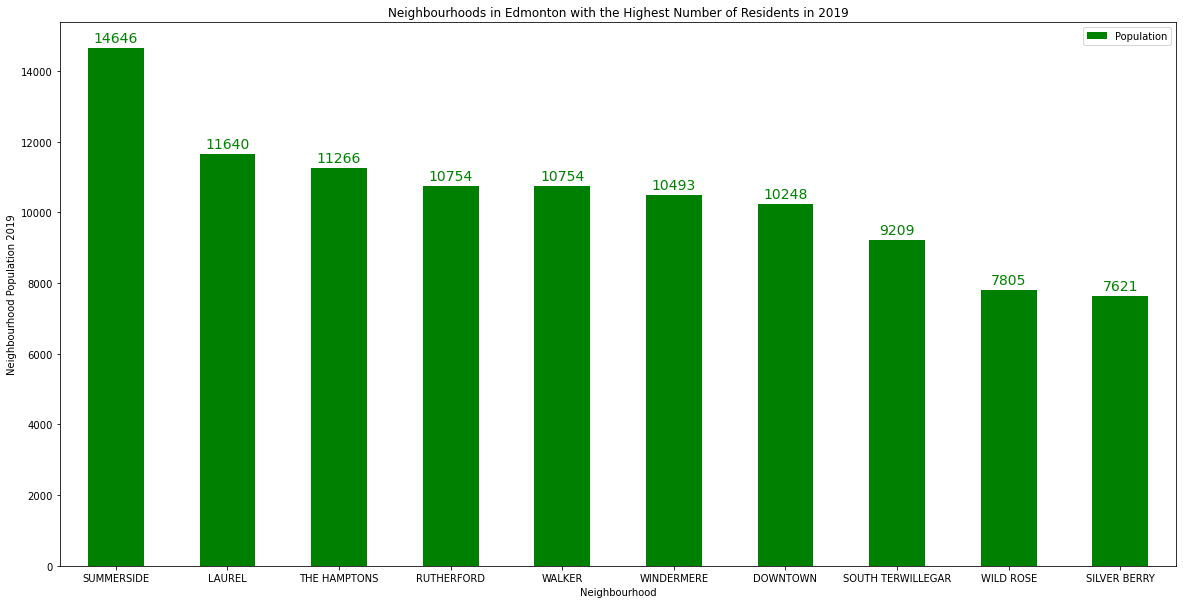

In [24]:
#chart population top 10
population_graph = yeg_population_top10[['Neighbourhood','Population']]

population_graph.set_index('Neighbourhood',inplace = True)

ax = population_graph.plot(kind='bar', figsize=(20, 10), rot=0, color='green')

ax.set_ylabel('Neighbourhood Population 2019')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Edmonton with the Highest Number of Residents in 2019')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
                color='green',
               )

plt.show()

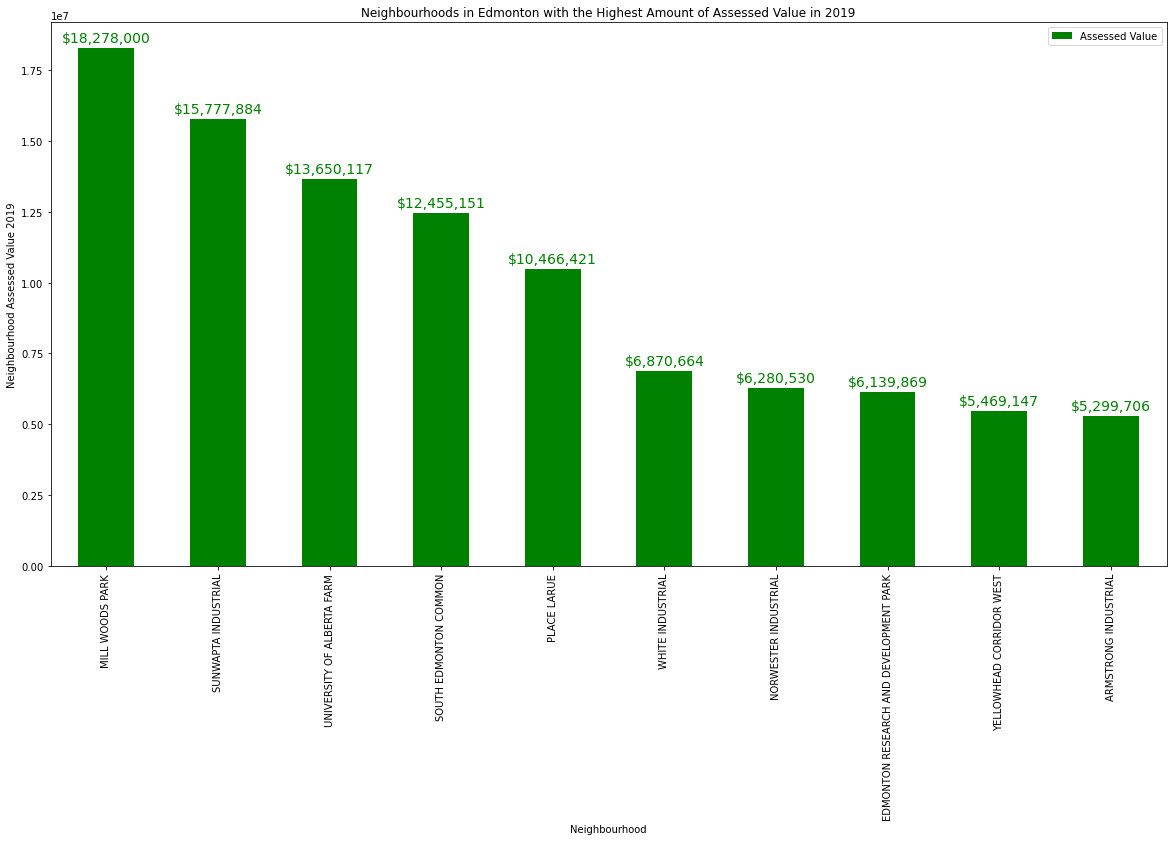

In [25]:
#chart assessed value top 10
value_graph = yeg_value_top10[['Neighbourhood','Assessed Value']]

value_graph.set_index('Neighbourhood',inplace = True)

ax = value_graph.plot(kind='bar', figsize=(20, 10), rot=90, color='green')

ax.set_ylabel('Neighbourhood Assessed Value 2019')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Edmonton with the Highest Amount of Assessed Value in 2019')

for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height(),decimals=0), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0,10),
                textcoords='offset points', 
                fontsize = 14,
                color='green',
               )

plt.show()

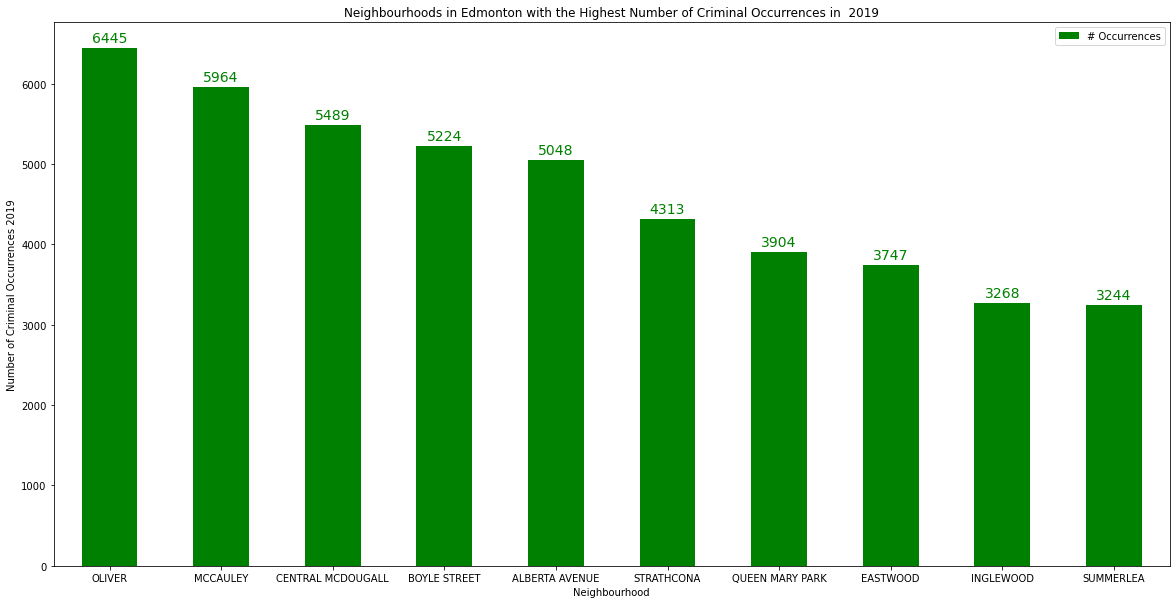

In [26]:
#chart criminal occurrences
crime_graph = yeg_crime_top10[['Neighbourhood','# Occurrences']]

crime_graph.set_index('Neighbourhood',inplace = True)

ax = crime_graph.plot(kind='bar', figsize=(20, 10), rot=0, color='green')

ax.set_ylabel('Number of Criminal Occurrences 2019')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Edmonton with the Highest Number of Criminal Occurrences in  2019')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
                color='green',
               )

plt.show()

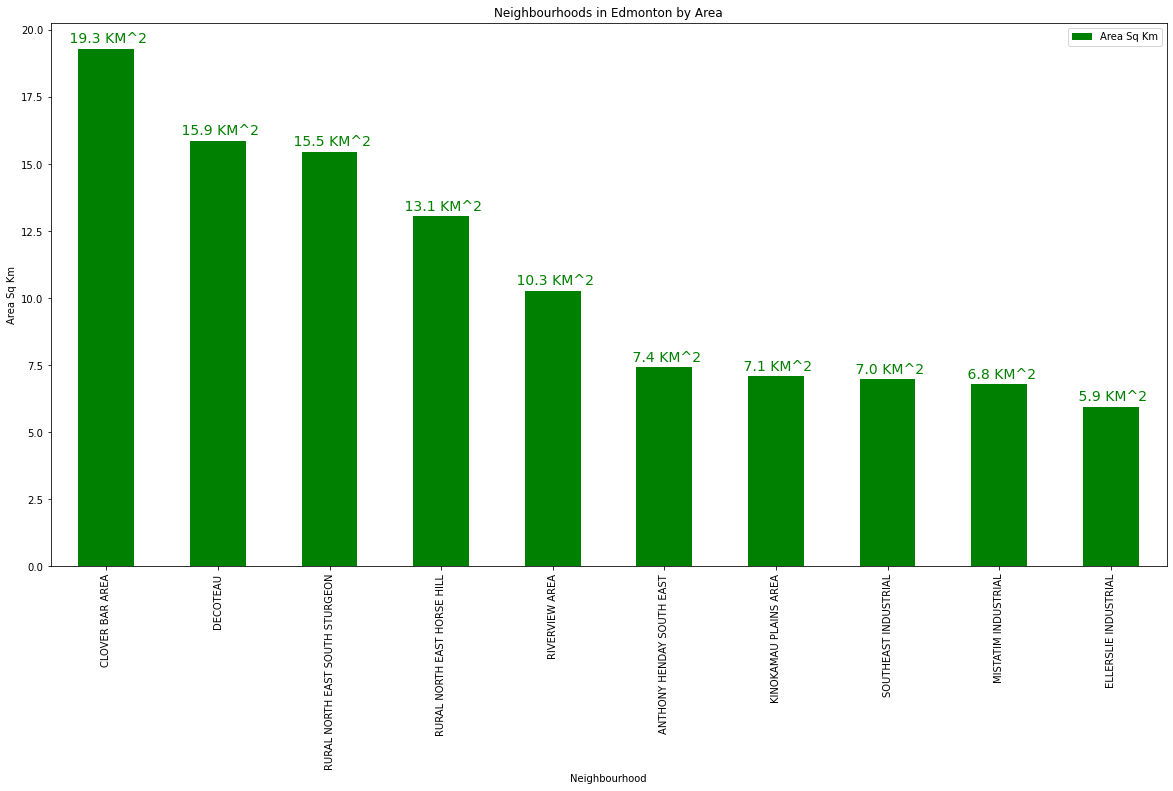

In [27]:
#chart neighbourhoods by area
area_graph = yeg_area_top10[['Neighbourhood','Area Sq Km']]

area_graph.set_index('Neighbourhood',inplace = True)

ax = area_graph.plot(kind='bar', figsize=(20, 10), rot=90, color='green')

ax.set_ylabel('Area Sq Km')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Edmonton by Area')

for p in ax.patches:
    ax.annotate(' {:,.1f} KM^2'.format(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
                color='green',
               )

plt.show()

In [28]:
CLIENT_ID = 'U0OWUYRP10WK5UFHIVQGDEKRQLZBSFYRALYTWAF0OBVJHIZ4'
CLIENT_SECRET = 'R2BLV2WI204CLFJ5GTAS1OR0U2AFMKZV5UTWI20OREP30SZQ' 
VERSION = '20201124'
LIMIT = 30
radius = 500
print('My foursquare credentails are:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My foursquare credentails are:
CLIENT_ID: U0OWUYRP10WK5UFHIVQGDEKRQLZBSFYRALYTWAF0OBVJHIZ4
CLIENT_SECRET:R2BLV2WI204CLFJ5GTAS1OR0U2AFMKZV5UTWI20OREP30SZQ


In [29]:
address = 'Edmonton, CA'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

53.535411 -113.507996


In [30]:
# Adding a dynamicSearch Radius column into dataframe, and re-ordering columns
# The new Search Radius will be used in the Foursquare API search query
yeg_df["Search Radius"] = yeg_df["Area Sq Km"].apply(lambda x: round(sqrt(x/pi)*500))
yeg_df

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude,# Occurrences,Neighbourhood Number,Neighbourhood Name,Population,Area Sq Km,Search Radius
113,EDMONTON ENERGY AND TECHNOLOGY PARK,2681.0,Ward 4,546864,53.652079,-113.433099,527,2681,Edmonton Energy And Technology Park,454,53.400728,2061
82,CLOVER BAR AREA,2160.0,Ward 7,2557284,53.574501,-113.342751,356,2160,Clover Bar Area,0,19.303526,1239
97,DECOTEAU,6663.0,Ward 12,642165,53.393302,-113.357886,104,6663,Decoteau,113,15.865110,1124
309,RURAL NORTH EAST SOUTH STURGEON,2690.0,Ward 4,725630,53.617281,-113.336562,116,2690,Rural North East South Sturgeon,623,15.450757,1109
308,RURAL NORTH EAST HORSE HILL,2670.0,Ward 4,1404438,53.639804,-113.352358,291,2670,Rural North East Horse Hill,410,13.057379,1019
...,...,...,...,...,...,...,...,...,...,...,...,...
56,BROWN INDUSTRIAL,3050.0,Ward 2,3198055,53.581849,-113.566697,132,3050,Brown Industrial,0,0.375578,173
21,ARGYLL,6010.0,Ward 11,393525,53.501593,-113.463868,163,6010,Argyll,789,0.359054,169
89,CROMDALE,1070.0,Ward 6,268956,53.558862,-113.467791,1340,1070,Cromdale,1706,0.358879,169
131,GAINER INDUSTRIAL,6250.0,Ward 8,4845000,53.517757,-113.435960,195,6250,Gainer Industrial,0,0.342465,165


In [31]:
# Defining a function to get nearby venues, using the Foursquare API, and extracting relevant information from the JSON response
# The function returns nearby venues in that Planning Area
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude_y', 
                  'Longitude_y', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
# Calling the user-defined function, and saving the results into a variable
yeg_venues = getNearbyVenues(names=yeg_df['Neighbourhood'],
                                   latitudes=yeg_df['Latitude'],
                                   longitudes=yeg_df['Longitude'],
                                   radius=yeg_df['Search Radius']
                                  )

EDMONTON ENERGY AND TECHNOLOGY PARK
CLOVER BAR AREA
DECOTEAU
RURAL NORTH EAST SOUTH STURGEON
RURAL NORTH EAST HORSE HILL
RIVERVIEW AREA
ANTHONY HENDAY SOUTH EAST
KINOKAMAU PLAINS AREA
SOUTHEAST INDUSTRIAL
MISTATIM INDUSTRIAL
ELLERSLIE INDUSTRIAL
WINTERBURN INDUSTRIAL AREA EAST
CHAPPELLE AREA
WINDERMERE
ANTHONY HENDAY
ANTHONY HENDAY SOUTH WEST
WINTERBURN INDUSTRIAL AREA WEST
EDGEMONT
SUMMERSIDE
KESWICK AREA
MAPLE RIDGE INDUSTRIAL
WINDERMERE AREA
RAMPART INDUSTRIAL
THE UPLANDS
THE ORCHARDS AT ELLERSLIE
PYLYPOW INDUSTRIAL
ANTHONY HENDAY BIG LAKE
ANTHONY HENDAY TERWILLEGAR
ANTHONY HENDAY RAMPART
AMBLESIDE
RIVER VALLEY TERWILLEGAR
RIVER'S EDGE
UNIVERSITY OF ALBERTA FARM
ROPER INDUSTRIAL
THE HAMPTONS
GORMAN
RIVER VALLEY WINDERMERE
LAUREL
ANTHONY HENDAY SOUTH
GRIESBACH
GOODRIDGE CORNERS
STRATHCONA INDUSTRIAL PARK
ROSENTHAL
CHARLESWORTH
SECORD
WALKER
PARSONS INDUSTRIAL
EASTGATE BUSINESS PARK
MCCONACHIE AREA
OTTEWELL
TAMARACK
RIVER VALLEY OLESKIW
ANTHONY HENDAY MISTATIM
HAYS RIDGE AREA
TRUMPETE

In [33]:
print (yeg_venues.shape)
yeg_venues

(923, 7)


,Neighbourhood,Latitude_y,Longitude_y,Venue,Venue Latitude,Venue Longitude,Venue Category
0,EDMONTON ENERGY AND TECHNOLOGY PARK,53.652079,-113.433099,Petro-Canada,53.639967,-113.429257,Gas Station
1,CLOVER BAR AREA,53.574501,-113.342751,Livingston International,53.575973,-113.326236,Transportation Service
2,RURAL NORTH EAST SOUTH STURGEON,53.617281,-113.336562,Raven Crest Golf & Country Club,53.613329,-113.341788,Golf Course
3,RURAL NORTH EAST SOUTH STURGEON,53.617281,-113.336562,Country Club Tour,53.613342,-113.341863,Golf Course
4,RURAL NORTH EAST SOUTH STURGEON,53.617281,-113.336562,The Quarry,53.624650,-113.328342,Golf Course
...,...,...,...,...,...,...,...
918,BROWN INDUSTRIAL,53.581849,-113.566697,cafe del sol kitchen,53.581779,-113.566807,Mexican Restaurant
919,CROMDALE,53.558862,-113.467791,Mario's Repainting,53.557821,-113.469042,Construction & Landscaping
920,CROMDALE,53.558862,-113.467791,Jla multiservices ltd,53.558028,-113.468556,Construction & Landscaping
921,GAINER INDUSTRIAL,53.517757,-113.435960,Burger Baron,53.517656,-113.435465,Burger Joint


In [34]:
print("Number of unique venue categories in Edmonton Neighbourhods:{}".format(len(yeg_venues["Venue Category"].unique())))

Number of unique venue categories in Edmonton Neighbourhods:211


In [35]:
# Dropping duplicated venues from the dataframe
yeg_venues_deduplicated = yeg_venues.drop_duplicates(subset='Venue')
print('Number of duplicated venues removed {}'.format(yeg_venues.shape[0]-yeg_venues_deduplicated.shape[0]))

Number of duplicated venues removed 224


In [36]:
print(yeg_venues_deduplicated.shape)
yeg_venues_deduplicated

(699, 7)


,Neighbourhood,Latitude_y,Longitude_y,Venue,Venue Latitude,Venue Longitude,Venue Category
0,EDMONTON ENERGY AND TECHNOLOGY PARK,53.652079,-113.433099,Petro-Canada,53.639967,-113.429257,Gas Station
1,CLOVER BAR AREA,53.574501,-113.342751,Livingston International,53.575973,-113.326236,Transportation Service
2,RURAL NORTH EAST SOUTH STURGEON,53.617281,-113.336562,Raven Crest Golf & Country Club,53.613329,-113.341788,Golf Course
3,RURAL NORTH EAST SOUTH STURGEON,53.617281,-113.336562,Country Club Tour,53.613342,-113.341863,Golf Course
4,RURAL NORTH EAST SOUTH STURGEON,53.617281,-113.336562,The Quarry,53.624650,-113.328342,Golf Course
...,...,...,...,...,...,...,...
910,ABBOTTSFIELD,53.571447,-113.388427,Abbottsfield Mall,53.571315,-113.390580,Shopping Mall
912,SHEFFIELD INDUSTRIAL,53.560498,-113.591328,Thanh Tam Vietnamese Noodle House,53.560034,-113.590108,Vietnamese Restaurant
913,SHEFFIELD INDUSTRIAL,53.560498,-113.591328,Saint Pete's,53.559880,-113.589607,Speakeasy
914,SHEFFIELD INDUSTRIAL,53.560498,-113.591328,High Park,53.559420,-113.591447,Neighborhood


In [37]:
# Getting the top 10 venue categories by all venue categories combined
yeg_venue_count = yeg_venues_deduplicated[['Neighbourhood', 'Venue Category']].groupby('Venue Category').count()
yeg_venue_top10 = yeg_venue_count.sort_values(by='Neighbourhood', ascending=False).rename(columns={'Neighbourhood':'Count'}).head(10)
yeg_venue_top10.reset_index(drop=False, inplace=True)
yeg_venue_top10

,Venue Category,Count
0,Construction & Landscaping,31
1,Park,19
2,Grocery Store,19
3,Pizza Place,19
4,Café,17
5,Vietnamese Restaurant,17
6,Home Service,16
7,Restaurant,12
8,Bakery,11
9,Liquor Store,11


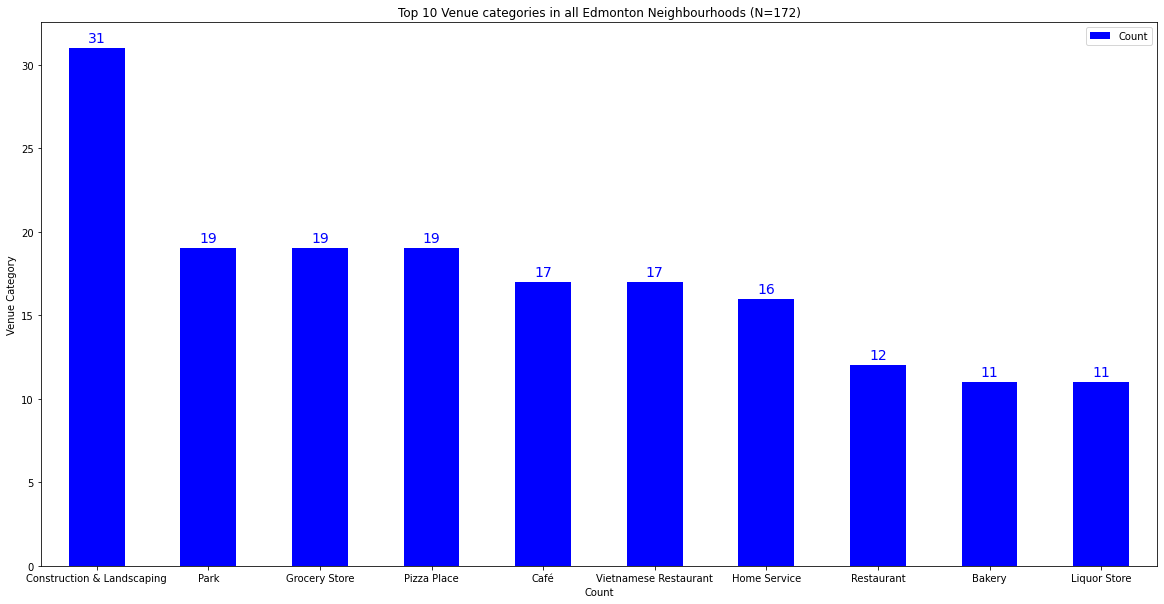

In [38]:
# Plotting bar chart
area_graph = yeg_venue_top10[['Venue Category','Count']]

area_graph.set_index('Venue Category',inplace = True)

ax = area_graph.plot(kind='bar', figsize=(20, 10), rot=0, color='blue')

ax.set_ylabel('Venue Category')
ax.set_xlabel('Count')
ax.set_title(f'Top 10 Venue categories in all Edmonton Neighbourhoods (N={yeg_venue_top10.Count.sum()})')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
                color='blue',
               )

plt.show()

In [39]:
# Getting the Count Venues in all Neighbourhoods
yeg_hoods_count = yeg_venues_deduplicated[['Neighbourhood','Venue']].groupby('Neighbourhood').count().sort_values(by='Venue', ascending=False).rename(columns={'Venue':'Count'})
#yeg_hoods_count = yeg_venues_deduplicated[['Neighbourhood', 'Venue']]
#yeg_hoods_top10 = yeg_hoods_count.sort_values(by='Venue', ascending=False).rename(columns={'Venue':'Count'}).head(223)
#yeg_hoods_top10.reset_index(drop=False, inplace=True)
#yeg_hoods_top10
yeg_hoods_count

,Count
Neighbourhood,
DOWNTOWN,29
QUEEN ALEXANDRA,26
STRATHCONA,22
MCCAULEY,22
ELLERSLIE INDUSTRIAL,17
...,...
RHATIGAN RIDGE,1
RAMSAY HEIGHTS,1
RAMPART INDUSTRIAL,1


In [40]:
# one hot encoding
yeg_onehot = pd.get_dummies(yeg_venues_deduplicated[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
yeg_onehot.insert(loc = 0, column = 'Neighbourhood', value = yeg_venues_deduplicated['Neighbourhood'])

# summing one-hot values
yeg_grouped_sum = yeg_onehot.groupby('Neighbourhood').sum().reset_index()
yeg_grouped_sum
#yeg_onehot

,Neighbourhood,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ABBOTTSFIELD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALBERTA AVENUE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ALBERTA PARK INDUSTRIAL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ALDERGROVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ALLARD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,WINTERBURN INDUSTRIAL AREA WEST,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,YELLOWHEAD CORRIDOR EAST,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234,YELLOWHEAD CORRIDOR WEST,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
235,YORK,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Calculating pearson correlations of all venue categories with population
correlation = yeg_grouped_sum.corrwith(yeg_df["Population"], method='pearson')
correlation.sort_values(ascending=False, inplace=True)
print(f'Pearson correlation of top 5 venue categories with Population density: \n{correlation[:5]} \n')
print(f'Pearson correlation of bottom 5 venue categories with Population density: \n{correlation[-5:]}')

Pearson correlation of top 5 venue categories with Population density: 
Bistro                  0.302514
Ethiopian Restaurant    0.302514
Theater                 0.282381
Comic Shop              0.280608
Butcher                 0.263498
dtype: float64 

Pearson correlation of bottom 5 venue categories with Population density: 
Clothing Store       -0.104686
Optical Shop         -0.107455
Salon / Barbershop   -0.107455
Scenic Lookout       -0.107455
Pizza Place          -0.114121
dtype: float64


In [42]:
# Calculating pearson correlations of all venue categories with Assessed Value
correlation = yeg_grouped_sum.corrwith(yeg_df["Assessed Value"], method='pearson')
correlation.sort_values(ascending=False, inplace=True)
print(f'Pearson correlation of top 5 venue categories with Assessed Value: \n{correlation[:5]} \n')
print(f'Pearson correlation of bottom 5 venue categories with Assessed Value: \n{correlation[-5:]}')

Pearson correlation of top 5 venue categories with Assessed Value: 
Construction & Landscaping    0.189095
Food Court                    0.180161
Warehouse Store               0.180161
Pool Hall                     0.180161
Light Rail Station            0.173022
dtype: float64 

Pearson correlation of bottom 5 venue categories with Assessed Value: 
Spa                   -0.054163
Rental Car Location   -0.054584
Thai Restaurant       -0.058270
Park                  -0.061658
Business Service      -0.068092
dtype: float64


In [43]:
# Calculating pearson correlations of all venue categories with Criminal Occurrences
correlation = yeg_grouped_sum.corrwith(yeg_df["# Occurrences"], method='pearson')
correlation.sort_values(ascending=False, inplace=True)
print(f'Pearson correlation of top 5 venue categories with Criminal Occurrences: \n{correlation[:5]} \n')
print(f'Pearson correlation of bottom 5 venue categories with Criminal Occurrences: \n{correlation[-5:]}')

Pearson correlation of top 5 venue categories with Criminal Occurrences: 
Butcher                0.449837
Arts & Crafts Store    0.441500
Recreation Center      0.433575
Comic Shop             0.350677
Dog Run                0.345037
dtype: float64 

Pearson correlation of bottom 5 venue categories with Criminal Occurrences: 
Business Service     -0.058910
Deli / Bodega        -0.059184
Convenience Store    -0.072046
Café                 -0.075547
Mexican Restaurant   -0.081600
dtype: float64


In [44]:
# Calculating pearson correlations of all venue categories with Area
correlation = yeg_grouped_sum.corrwith(yeg_df["Area Sq Km"], method='pearson')
correlation.sort_values(ascending=False, inplace=True)
print(f'Pearson correlation of top 5 venue categories with Area: \n{correlation[:5]} \n')
print(f'Pearson correlation of bottom 5 venue categories with Area: \n{correlation[-5:]}')

Pearson correlation of top 5 venue categories with Area: 
Hardware Store          0.211416
Pizza Place             0.168791
Fast Food Restaurant    0.118012
Art Gallery             0.091286
Bus Station             0.089743
dtype: float64 

Pearson correlation of bottom 5 venue categories with Area: 
Chinese Restaurant   -0.033196
Bar                  -0.033236
Restaurant           -0.034894
Sandwich Place       -0.040169
Park                 -0.046719
dtype: float64


In [45]:
# Showing the top 5 venue categories for each Planning Area
num_top_venues = 5

for area in yeg_grouped_sum['Neighbourhood']:
    print("----"+area+"----")
    temp = yeg_grouped_sum[yeg_grouped_sum['Neighbourhood'] == area].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ABBOTTSFIELD----
            venue  freq
0   Shopping Mall   1.0
1     Bus Station   1.0
2  Shopping Plaza   1.0
3             ATM   0.0
4    Neighborhood   0.0


----ALBERTA AVENUE----
         venue  freq
0  Music Venue   1.0
1         Café   1.0
2      Theater   1.0
3       Bakery   1.0
4          ATM   0.0


----ALBERTA PARK INDUSTRIAL----
                    venue  freq
0  Furniture / Home Store   1.0
1       Electronics Store   1.0
2            Home Service   1.0
3             Music Venue   0.0
4            Neighborhood   0.0


----ALDERGROVE----
                        venue  freq
0              Lingerie Store   1.0
1           Convenience Store   1.0
2  Construction & Landscaping   1.0
3                    Pharmacy   0.0
4     New American Restaurant   0.0


----ALLARD----
                     venue  freq
0         Business Service   1.0
1                      ATM   0.0
2              Music Store   0.0
3             Neighborhood   0.0
4  New American Restaurant   0.0


----

                    venue  freq
0  Transportation Service   1.0
1                     ATM   0.0
2   Performing Arts Venue   0.0
3             Music Store   0.0
4             Music Venue   0.0


----CLOVERDALE----
         venue  freq
0  Music Venue   2.0
1         Park   1.0
2     Ski Area   1.0
3         Café   1.0
4       Museum   1.0


----CORONET ADDITION INDUSTRIAL----
                    venue  freq
0  Thrift / Vintage Store   1.0
1             Karaoke Bar   1.0
2                     ATM   0.0
3             Music Venue   0.0
4            Neighborhood   0.0


----CORONET INDUSTRIAL----
                   venue  freq
0  Vietnamese Restaurant   1.0
1                  Diner   1.0
2      Korean Restaurant   1.0
3                 Bakery   1.0
4                    ATM   0.0


----CPR IRVINE----
                   venue  freq
0           Burger Joint   1.0
1                   Café   1.0
2                Factory   1.0
3                    ATM   0.0
4  Performing Arts Venue   0.0


----CRE

           venue  freq
0           Park   1.0
1            ATM   0.0
2  Radio Station   0.0
3    Music Store   0.0
4    Music Venue   0.0


----HERITAGE VALLEY TOWN CENTRE AREA----
                     venue  freq
0                      ATM   1.0
1               Campground   1.0
2              Music Store   0.0
3             Neighborhood   0.0
4  New American Restaurant   0.0


----HIGH PARK----
                   venue  freq
0    Rental Car Location   1.0
1                    ATM   0.0
2  Performing Arts Venue   0.0
3            Music Venue   0.0
4           Neighborhood   0.0


----HILLVIEW----
                  venue  freq
0  Gym / Fitness Center   1.0
1    Mexican Restaurant   1.0
2                   ATM   0.0
3           Music Venue   0.0
4          Neighborhood   0.0


----HOLYROOD----
                   venue  freq
0           Dance Studio   1.0
1                    ATM   0.0
2  Performing Arts Venue   0.0
3            Music Venue   0.0
4           Neighborhood   0.0


----HOMES

                   venue  freq
0           Home Service   1.0
1                    ATM   0.0
2  Performing Arts Venue   0.0
3            Music Venue   0.0
4           Neighborhood   0.0


----MILL CREEK RAVINE SOUTH----
           venue  freq
0     Food Truck   1.0
1  Radio Station   0.0
2    Music Store   0.0
3    Music Venue   0.0
4   Neighborhood   0.0


----MILL WOODS PARK----
                   venue  freq
0       Community Center   1.0
1           Hockey Arena   1.0
2                   Park   1.0
3                    ATM   0.0
4  Performing Arts Venue   0.0


----MILLER----
           venue  freq
0           Park   1.0
1  Shopping Mall   1.0
2            ATM   0.0
3         Museum   0.0
4    Music Venue   0.0


----MINCHAU----
           venue  freq
0  Jewelry Store   1.0
1            Bar   1.0
2            ATM   0.0
3      Pet Store   0.0
4   Neighborhood   0.0


----MISTATIM INDUSTRIAL----
          venue  freq
0    Print Shop   1.0
1    Smoke Shop   1.0
2       Dog Run   1.0
3

----SAKAW----
                 venue  freq
0  Filipino Restaurant   1.0
1           Playground   1.0
2          Pizza Place   1.0
3                  ATM   0.0
4                 Park   0.0


----SATOO----
          venue  freq
0   Art Gallery   1.0
1           ATM   0.0
2     Pet Store   0.0
3   Music Venue   0.0
4  Neighborhood   0.0


----SHEFFIELD INDUSTRIAL----
                           venue  freq
0                   Neighborhood   1.0
1          Vietnamese Restaurant   1.0
2                      Speakeasy   1.0
3                            ATM   0.0
4  Paper / Office Supplies Store   0.0


----SOUTH EDMONTON COMMON----
                  venue  freq
0         Women's Store   2.0
1                  Bank   1.0
2  Fast Food Restaurant   1.0
3   Sporting Goods Shop   1.0
4        Hardware Store   1.0


----SOUTH TERWILLEGAR----
           venue  freq
0  Shopping Mall   1.0
1     Restaurant   1.0
2    Coffee Shop   1.0
3            Spa   1.0
4   Liquor Store   1.0


----SOUTHEAST INDUS

                     venue  freq
0             Liquor Store   1.0
1           Clothing Store   1.0
2      American Restaurant   1.0
3     Fast Food Restaurant   1.0
4  New American Restaurant   0.0


----YOUNGSTOWN INDUSTRIAL----
                venue  freq
0   Accessories Store   1.0
1          Kids Store   1.0
2  Dim Sum Restaurant   1.0
3   Electronics Store   1.0
4           Pet Store   1.0




In [46]:
#sorting neighbourhoods by most common venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = yeg_grouped_sum['Neighbourhood']

for ind in np.arange(yeg_grouped_sum.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(yeg_grouped_sum.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABBOTTSFIELD,Bus Station,Shopping Plaza,Shopping Mall,Yoga Studio,Electronics Store,Fondue Restaurant,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
1,ALBERTA AVENUE,Theater,Music Venue,Café,Bakery,Food Service,Food & Drink Shop,Fondue Restaurant,Flower Shop,Filipino Restaurant,Fast Food Restaurant
2,ALBERTA PARK INDUSTRIAL,Furniture / Home Store,Home Service,Electronics Store,Yoga Studio,Eastern European Restaurant,Food & Drink Shop,Fondue Restaurant,Flower Shop,Filipino Restaurant,Fast Food Restaurant
3,ALDERGROVE,Convenience Store,Construction & Landscaping,Lingerie Store,Eastern European Restaurant,Food & Drink Shop,Fondue Restaurant,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
4,ALLARD,Business Service,Yoga Studio,Food Service,Food & Drink Shop,Fondue Restaurant,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Factory


In [48]:
# set number of clusters
kclusters = 5
yeg_grouped_clustering = yeg_grouped_sum.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(yeg_grouped_clustering)


# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 4, 0, 3, 4, 0, 0, 0], dtype=int32)

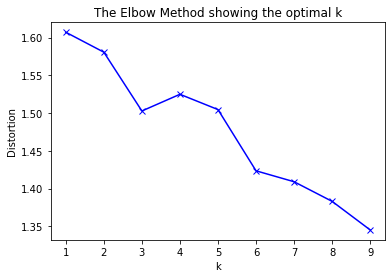

In [49]:
# double check number of cluster with an elbow chart
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(yeg_grouped_clustering)
    kmeanModel.fit(yeg_grouped_clustering)
    distortions.append(sum(np.min(cdist(yeg_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / yeg_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

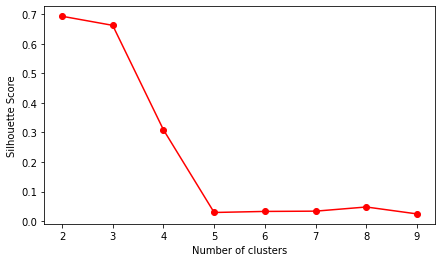

In [50]:
# double check with silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score


max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(yeg_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(yeg_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(7,4))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [51]:
# merging venues with dataframe
yeg_df_venues3 = pd.merge(yeg_df, yeg_venues_deduplicated, how ='inner', left_on = 'Neighbourhood', right_on = 'Neighbourhood', validate ="1:m")
yeg_df_venues3.columns

Index(['Neighbourhood', 'Neighbourhood ID', 'Ward', 'Assessed Value',
       'Latitude', 'Longitude', '# Occurrences', 'Neighbourhood Number',
       'Neighbourhood Name', 'Population', 'Area Sq Km', 'Search Radius',
       'Latitude_y', 'Longitude_y', 'Venue', 'Venue Latitude',
       'Venue Longitude', 'Venue Category'],
      dtype='object')

In [52]:
#drop unnecessary columns and create final merge table
yeg_df_venues2=yeg_df_venues3.drop(['Neighbourhood', 'Neighbourhood ID',
       'Latitude_y', 'Longitude_y'],axis=1)
yeg_df_venues2

,Ward,Assessed Value,Latitude,Longitude,# Occurrences,Neighbourhood Number,Neighbourhood Name,Population,Area Sq Km,Search Radius,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ward 4,546864,53.652079,-113.433099,527,2681,Edmonton Energy And Technology Park,454,53.400728,2061,Petro-Canada,53.639967,-113.429257,Gas Station
1,Ward 7,2557284,53.574501,-113.342751,356,2160,Clover Bar Area,0,19.303526,1239,Livingston International,53.575973,-113.326236,Transportation Service
2,Ward 4,725630,53.617281,-113.336562,116,2690,Rural North East South Sturgeon,623,15.450757,1109,Raven Crest Golf & Country Club,53.613329,-113.341788,Golf Course
3,Ward 4,725630,53.617281,-113.336562,116,2690,Rural North East South Sturgeon,623,15.450757,1109,Country Club Tour,53.613342,-113.341863,Golf Course
4,Ward 4,725630,53.617281,-113.336562,116,2690,Rural North East South Sturgeon,623,15.450757,1109,The Quarry,53.624650,-113.328342,Golf Course
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,Ward 7,317930,53.571447,-113.388427,976,2010,Abbottsfield,1515,0.409629,181,Abbottsfield Mall,53.571315,-113.390580,Shopping Mall
695,Ward 1,1702141,53.560498,-113.591328,215,4490,Sheffield Industrial,0,0.379684,174,Thanh Tam Vietnamese Noodle House,53.560034,-113.590108,Vietnamese Restaurant
696,Ward 1,1702141,53.560498,-113.591328,215,4490,Sheffield Industrial,0,0.379684,174,Saint Pete's,53.559880,-113.589607,Speakeasy
697,Ward 1,1702141,53.560498,-113.591328,215,4490,Sheffield Industrial,0,0.379684,174,High Park,53.559420,-113.591447,Neighborhood


In [53]:
#drop cluster labels to create new datatset
#neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', inplace = True)

In [54]:
# apply uppercase to neighbourhood name in main dataframe to perform the lookup
yeg_df['Neighbourhood Name']=yeg_df['Neighbourhood Name'].str.upper()
yeg_df.head()

,Neighbourhood,Neighbourhood ID,Ward,Assessed Value,Latitude,Longitude,# Occurrences,Neighbourhood Number,Neighbourhood Name,Population,Area Sq Km,Search Radius
113,EDMONTON ENERGY AND TECHNOLOGY PARK,2681.0,Ward 4,546864,53.652079,-113.433099,527,2681,EDMONTON ENERGY AND TECHNOLOGY PARK,454,53.400728,2061
82,CLOVER BAR AREA,2160.0,Ward 7,2557284,53.574501,-113.342751,356,2160,CLOVER BAR AREA,0,19.303526,1239
97,DECOTEAU,6663.0,Ward 12,642165,53.393302,-113.357886,104,6663,DECOTEAU,113,15.865110,1124
309,RURAL NORTH EAST SOUTH STURGEON,2690.0,Ward 4,725630,53.617281,-113.336562,116,2690,RURAL NORTH EAST SOUTH STURGEON,623,15.450757,1109
308,RURAL NORTH EAST HORSE HILL,2670.0,Ward 4,1404438,53.639804,-113.352358,291,2670,RURAL NORTH EAST HORSE HILL,410,13.057379,1019


In [55]:
# create new dataframe with all the information including cluster labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

yeg_merged = yeg_df

yeg_merged = yeg_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood Name')

yeg_merged

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

In [ ]:
# ensure no nulls in yeg_merged table to not get string to float error while doing the cluster mean formula
yeg_merged['Cluster Labels'] = yeg_merged['Cluster Labels'].fillna(0)
yeg_merged['Cluster Labels'].isnull()

In [ ]:
# convert cluster labels to yeg_merged table to not get string to float error while doing the cluster mean formula
yeg_merged['Cluster Labels'] = yeg_merged['Cluster Labels'].astype(int)
yeg_merged

In [ ]:
# Summary of cluster labels
yeg_merged['Cluster Labels'].value_counts()

In [ ]:
# create clusters map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(yeg_merged['Latitude'], yeg_merged['Longitude'], yeg_merged['Neighbourhood Name'],  yeg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
from IPython.display import HTML
import base64  

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = yeg_merged.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(yeg_merged)